In [1]:
# utilities
import pathlib
import pickle
import joblib
import pandas as pd
import numpy as np
import random
import re
import os
import spacy
import time
from collections import Counter


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# keras
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

# pytorch
import torch
import torchtext
from torchtext import datasets
from torchtext import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch.optim as optim

# data
from google.colab import drive
drive.mount('/content/drive')

# check
print("PyTorch Version : {}".format(torch.__version__))
print("Torch Text Version : {}".format(torchtext.__version__))

Mounted at /content/drive
PyTorch Version : 1.12.1+cu113
Torch Text Version : 0.13.1


In [2]:
# For CNN model (RUN THIS CELL)
max_words = 200
embed_len = 200
batch_size=100
n_filters=32
filters=[3,4,5]
# device = torch.device("mps")
device = torch.device("cuda")
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #input is [100,1,200,200] : batch size, 1,max words, embedding length
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[0],embed_len))
        self.pool = nn.MaxPool1d(2, 2)
        nrow1=int((max_words-filters[0]+1)/2)
        
        self.conv2 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[1],embed_len))
        nrow2=int((max_words-filters[1]+1)/2)
        
        self.conv3 = nn.Conv2d(in_channels=1,out_channels=n_filters, kernel_size=(filters[2],embed_len))
        nrow3=int((max_words-filters[2]+1)/2)
        
        
        self.fc1 = nn.Linear(n_filters*(nrow1+nrow2+nrow3), 1)
       
    def forward(self, x):
        t=self.conv1(x)
        x1 = self.pool(F.relu(self.conv1(x).squeeze(3)))
        x2 = self.pool(F.relu(self.conv2(x).squeeze(3)))
        x3 = self.pool(F.relu(self.conv3(x).squeeze(3)))
        x=torch.cat((x1, x2, x3),dim=2)
        x = torch.flatten(x,1) # flatten all dimensions except batch
        
        x = self.fc1(x)
        
        x=torch.flatten(x)
        
        return x

net = Net()

net.to(device)



Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 200), stride=(1, 1))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 32, kernel_size=(4, 200), stride=(1, 1))
  (conv3): Conv2d(1, 32, kernel_size=(5, 200), stride=(1, 1))
  (fc1): Linear(in_features=9440, out_features=1, bias=True)
)

In [3]:
# For CNN Model (RUN THIS CELL)
tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(name='twitter.27B', dim=200)
retrain=False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
if(retrain):
  for epoch in range(2):  # we know 2 epoch is the best

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          #  inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          # print statistics
          running_loss += loss.item()
          if i % 1000 == 999:    # print every 1000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
              running_loss = 0.0
      if(epoch ==1):
        PATH = f'/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/CNN/cnn.model.pth'
        torch.save(net.state_dict(), PATH)

print('Finished Training, model saved')

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [01:13<00:00, 16345.07it/s]


Finished Training, model saved


In [ ]:
# DON'T RUN THIS CELL
PATH = f'/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/CNN/cnn.model.pth'
net.load_state_dict(torch.load(PATH))
# net.load_state_dict(torch.load(PATH,map_location=lambda storage, location: 'cuda'))


correct = 0
running_loss=0.
total = 0
predictions=[]
with torch.no_grad():
    for data in test_loader:
        texts, labels = data[0].to(device), data[1].to(device)
        # texts, labels = data
        total += labels.size(0)
        outputs = net(texts)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        sigmoids=torch.sigmoid(outputs)
        sigmoids=(sigmoids>0.5)+0
        predictions += sigmoids.tolist()
        correct += (sigmoids.data == labels).sum().item()
accuracy=100*correct/total
loss=running_loss/total

print(f'accuracy of test data is: {accuracy:.1f}')
print(f'loss of test data is: {loss:.5f}')
print(predictions)

KeyboardInterrupt: ignored

In [4]:
# For CNN Model (RUN THIS CELL)
class ReadDataSet(torch.utils.data.Dataset):
     def __init__(self,file):
        super(ReadDataSet).__init__()
        csv=pd.read_csv(file,dtype={'target': np.float32, 'text': str})
        csv=csv[csv["text"].notnull()]
        
        # csv=csv[:100] # reduce the amount of data (for testing purpose)
        self.data=csv
     def __len__(self):
        return self.data.shape[0]
    
     def __getitem__(self,idx):
        return  self.data['target'].iloc[idx],self.data['text'].iloc[idx]
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    
    
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch),1, max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = global_vectors.get_vecs_by_tokens(tokens)
    return X_tensor, torch.tensor(Y)

def CNN_predict(loader, model_dir):
  net.load_state_dict(torch.load(model_dir))
  correct = 0
  running_loss=0.
  total = 0
  predictions=[]
  with torch.no_grad():
      for data in loader:
          texts, labels = data[0].to(device), data[1].to(device)
          # texts, labels = data
          total += labels.size(0)
          outputs = net(texts)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          sigmoids=torch.sigmoid(outputs)
          sigmoids=(sigmoids>0.5)+0
          predictions += sigmoids.tolist()
  return predictions

In [5]:
# RUN THIS CELL
from scipy.special import diric
# evaluate single model
def model_Evaluate(y_pred,y_test):
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#===================================================================================================================================
# Logistic, BNB, and SVM use the same transform function
def LBS_transform(X):
  # load tf-idf weight
  dir = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/Tf-idf/tfidf.joblib"
  vectoriser=joblib.load(dir)
  data = vectoriser.transform(X)
  return data

#===================================================================================================================================
def RNN_transform(X):
  max_words = 5000
  max_len = 200

  with open('/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/RNN/finalModel/tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
  sequences = tokenizer.texts_to_sequences(X)
  data = pad_sequences(sequences, maxlen=max_len)
  return data

#===================================================================================================================================
def CNN_transform(X):
  # All CNN transform is in ReadDataSet class
  data = X
  return data

#===================================================================================================================================
def Attention_transform(X):
  max_words = 5000
  max_len = 200

  with open('/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/RNN/finalModel/tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
  sequences = tokenizer.texts_to_sequences(X)
  data = pad_sequences(sequences, maxlen=max_len)
  return data

#===================================================================================================================================
# The same transmation function is used by Random Forest and AdaBoost
def RF_AdB_transform(X):
  #dir = "/content/drive/MyDrive/2018-2023 WPI/2022-2023 WPI Master's/Fall Semester/Machine Learning/CS 539 Final Project/Ensemble/RandomForest/tfidf_vect_RF_AdB.joblib"
  dir = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/RandomForest/tfidf_vect_RF_AdB.joblib"
  vectoriser = joblib.load(dir)
  data = vectoriser.transform(X)
  return data

#===================================================================================================================================
def load_and_predict(dir,X):
  ext = pathlib.Path(dir).suffix # file extension
  if ext == ".joblib":
    model = joblib.load(dir)
    y_pred = model.predict(X)
  elif ext == ".ckpt":
    model = keras.models.load_model(dir)
    y_pred = model.predict(X)
    y_pred = np.where(y_pred>0.5,1,0).ravel()
  elif ext == ".pickle":
    model = pickle.load(open(dir, 'rb'))
    y_pred = model.predict(X)
  elif ext == ".pth":
    y_pred = CNN_predict(X,dir)
  return y_pred

#===================================================================================================================================
# input for dir is directory of the model weight
# input for data is the transformed data for appropriate model
def Ensemble_predict(dir1, X1, dir2, X2, dir3, X3):
  # load model and predict
  y_pred1 = load_and_predict(dir1,X1)
  y_pred2 = load_and_predict(dir2,X2)
  y_pred3 = load_and_predict(dir3,X3)

  # final prediction
  final_pred=[];
  for i in range(0,len(y_pred1)):
    pred_list = [y_pred1[i],y_pred2[i],y_pred3[i]]
    #print(pred_list)
    count = Counter(pred_list)
    prediction = count.most_common(1)[0][0]
    final_pred.append(prediction)
  return final_pred


In [6]:
# RUN THIS CELL
# data for all other models
train=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/train_preprocessing.csv")
test=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/test_preprocessing.csv")
valid=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/valid_preprocessing.csv")

# data for CNN
train_dataset=ReadDataSet('/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/train_preprocessing.csv')         
test_dataset=ReadDataSet('/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/test_preprocessing.csv')         
valid_dataset=ReadDataSet('/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/valid_preprocessing.csv')  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=vectorize_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn=vectorize_batch)

# fill null values
train=train[train["text"].notnull()]
test=test[test["text"].notnull()]
valid=valid[valid["text"].notnull()]

# train['text'].fillna("", inplace = True)
# test['text'].fillna("", inplace = True)
# valid['text'].fillna("", inplace = True)

In [7]:
# RUN THIS CELL
# train test split
X_test=test['text']
y_test=test['target']

In [14]:
################### TRANSFORM DATA (RUN THIS CELL) ###################
X_test_LBS=LBS_transform(X_test)
X_test_RF_Ada=RF_AdB_transform(X_test)
X_test_RNN=RNN_transform(X_test)
X_test_Attention=Attention_transform(X_test)

In [9]:
################### MODEL WEIGHT (RUN THIS CELL) ###################
BNB = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/BNB/BNB.joblib"
Logistic = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/Logistic/Logistic.joblib"
SVC = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/SVC/SVC.joblib"
RNN = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/RNN/finalModel/cp.ckpt"
AdaBoost = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/AdaBoost/AdB.joblib"
RandForest = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/RandomForest/RF.joblib"
CNN = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/CNN/cnn.model.pth"
Attention = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/Attention/finalModel/cp.ckpt"

9958/9958 [==============================] - 41s 4ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78    159379
         1.0       0.77      0.82      0.79    159267

    accuracy                           0.79    318646
   macro avg       0.79      0.79      0.79    318646
weighted avg       0.79      0.79      0.79    318646



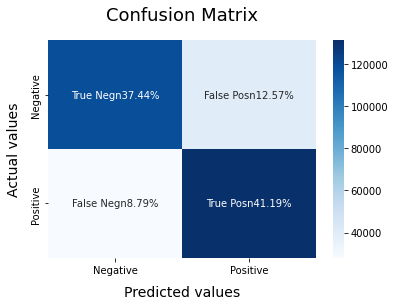

In [10]:
################### ENSEMBLE (RUN THIS CELL) ###################
ensemble_pred = Ensemble_predict(AdaBoost, X_test_RF_Ada, RNN, X_test_RNN, CNN, test_loader)
model_Evaluate(ensemble_pred,y_test)

9958/9958 [==============================] - 39s 4ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80    159379
         1.0       0.79      0.82      0.80    159267

    accuracy                           0.80    318646
   macro avg       0.80      0.80      0.80    318646
weighted avg       0.80      0.80      0.80    318646



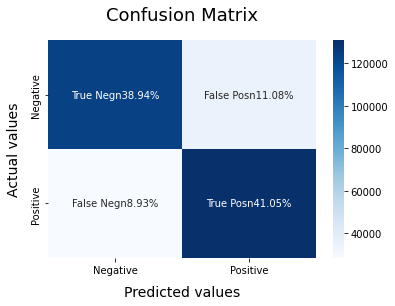

In [12]:
################### ENSEMBLE (RUN THIS CELL) ###################
ensemble_pred2 = Ensemble_predict(Logistic, X_test_LBS, RNN, X_test_RNN, CNN, test_loader)
model_Evaluate(ensemble_pred2,y_test)

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77    159379
         1.0       0.76      0.81      0.78    159267

    accuracy                           0.78    318646
   macro avg       0.78      0.78      0.78    318646
weighted avg       0.78      0.78      0.78    318646



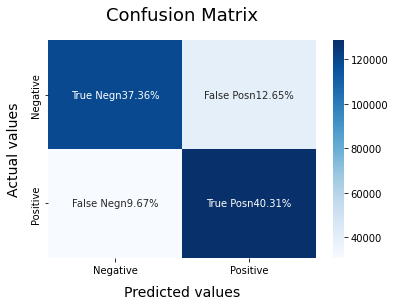

In [21]:
# Testing purpose only
y_pred_test = load_and_predict(SVC,X_test_LBS)
#print(y_pred_test)

model_Evaluate(y_pred_test,y_test)